In [1]:
# !pip install matplotlib

/home/onyxia/work/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


11180


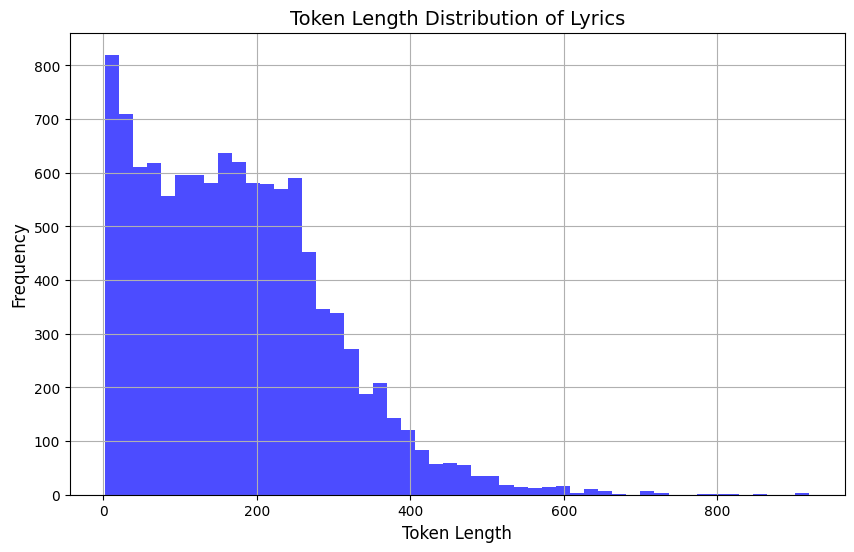

count    11180.000000
mean       175.366369
std        121.056405
min          2.000000
25%         77.000000
50%        164.000000
75%        250.000000
max        920.000000
Name: tokenized_length, dtype: float64

In [1]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import pandas as pd
import os
# import sys
from collections import Counter
lyrics_data = pd.read_csv('data/lyrics_midi_data.csv')
print(len(lyrics_data))
# Initialize the GPT-2 tokenizer
lyrics_tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Tokenize the lyrics and calculate token lengths
lyrics_data['tokenized_length'] = lyrics_data['lyrics'].apply(
    lambda x: len(lyrics_tokenizer.tokenize(x))
)

# Analyze tokenized lengths
token_length_stats = lyrics_data['tokenized_length'].describe()

plt.figure(figsize=(10, 6))
plt.hist(lyrics_data['tokenized_length'], bins=50, color='blue', alpha=0.7)
plt.title('Token Length Distribution of Lyrics', fontsize=14)
plt.xlabel('Token Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

token_length_stats


In [2]:
lyrics_data

,lyrics,midi_path,tokenized_length
0,In sleep he sang to me\nin dreams he came\ntha...,lmd-full_and_reddit_MIDI_dataset/sentenceWord_...,107
1,I have plans and schemes\nAnd I have hopes and...,lmd-full_and_reddit_MIDI_dataset/sentenceWord_...,82
2,I get up and nothing gets me You got\nit tough...,lmd-full_and_reddit_MIDI_dataset/sentenceWord_...,48
3,Man a hot like seven inches\nfrom the midday I...,lmd-full_and_reddit_MIDI_dataset/sentenceWord_...,381
4,We come from the land of the ice and snow\nfro...,lmd-full_and_reddit_MIDI_dataset/sentenceWord_...,177
...,...,...,...
11175,Remember when you were young\nhow the hero was...,lmd-full_and_reddit_MIDI_dataset/sentenceWord_...,134
11176,Girl tell me only that I have heart for\nand y...,lmd-full_and_reddit_MIDI_dataset/sentenceWord_...,53
11177,Yo tell you what I want\nWhat I really really ...,lmd-full_and_reddit_MIDI_dataset/sentenceWord_...,525
11178,Been around the world I\nI I I find my baby\nI...,lmd-full_and_reddit_MIDI_dataset/sentenceWord_...,93


In [2]:
from miditok import TSD, TokenizerConfig
from pathlib import Path
def initialize_midi_tokenizer(tokenizer_file="tokenizer/tokenizer.json"):
    config = TokenizerConfig(
        # num_velocities=1,
        use_velocities=False,
        use_chords=False,
        use_rests=False,
        use_tempos=False,
        use_time_signatures=False,
    )
    midi_tokenizer = TSD(config)
    return midi_tokenizer.from_pretrained(Path(tokenizer_file))
    # return midi_tokenizer

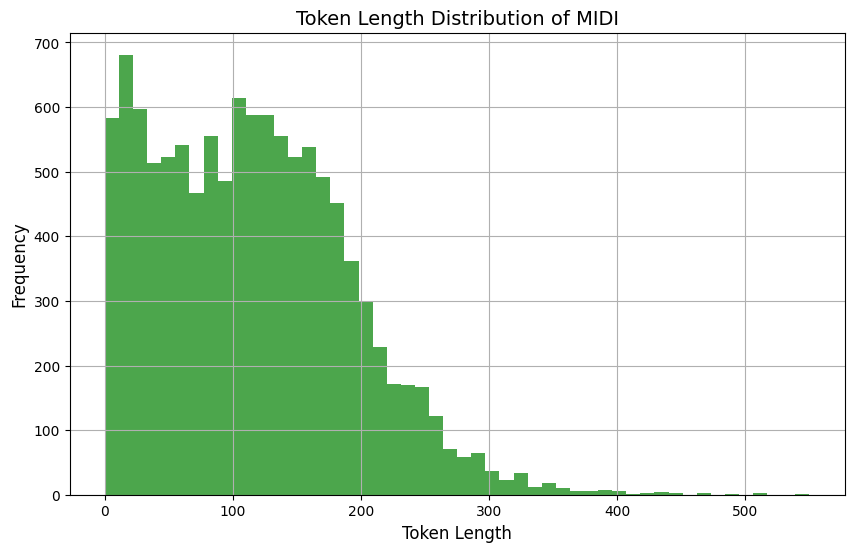

count    11180.000000
mean       114.953936
std         75.629433
min          0.000000
25%         52.000000
50%        110.000000
75%        166.000000
max        550.000000
Name: midi_tokenized_length, dtype: float64


In [3]:
import matplotlib.pyplot as plt
from symusic import Score
# from miditok import TSD, TokenizerConfig

# # Load MIDI Tokenizer
# config = TokenizerConfig(
#     num_velocities=1,
#     # use_velocities=False,
#     use_chords=False,
#     use_rests=False,
#     use_tempos=False,
#     use_time_signatures=False,
# )

# midi_tokenizer = TSD(config)

midi_tokenizer = initialize_midi_tokenizer()
# Tokenize MIDI sequences and calculate token lengths
def get_midi_token_length(midi_path):
    try:
        midi_score = Score(midi_path)
        tokenized = midi_tokenizer.encode(midi_score)[0].ids
        return len(tokenized)
    except Exception as e:
        print(f"Error processing {midi_path}: {e}")
        return 0
root_dir = "data"
lyrics_data['midi_path'] = lyrics_data['midi_path'].apply(lambda x: os.path.join(root_dir, x))

lyrics_data['midi_tokenized_length'] = lyrics_data['midi_path'].apply(get_midi_token_length)

# Analyze tokenized lengths
midi_length_stats = lyrics_data['midi_tokenized_length'].describe()

plt.figure(figsize=(10, 6))
plt.hist(lyrics_data['midi_tokenized_length'], bins=50, color='green', alpha=0.7)
plt.title('Token Length Distribution of MIDI', fontsize=14)
plt.xlabel('Token Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

print(midi_length_stats)

In [15]:
filtered_lyrics_data = lyrics_data[lyrics_data['midi_tokenized_length'] > 10]  # Adjust threshold as needed

In [16]:
filtered_lyrics_data

,lyrics,midi_path,tokenized_length,midi_tokenized_length
0,In sleep he sang to me\nin dreams he came\ntha...,../data/lmd-full_and_reddit_MIDI_dataset/sente...,107,255
1,I have plans and schemes\nAnd I have hopes and...,../data/lmd-full_and_reddit_MIDI_dataset/sente...,82,235
2,I get up and nothing gets me You got\nit tough...,../data/lmd-full_and_reddit_MIDI_dataset/sente...,48,131
3,Man a hot like seven inches\nfrom the midday I...,../data/lmd-full_and_reddit_MIDI_dataset/sente...,381,1073
4,We come from the land of the ice and snow\nfro...,../data/lmd-full_and_reddit_MIDI_dataset/sente...,177,464
...,...,...,...,...
11175,Remember when you were young\nhow the hero was...,../data/lmd-full_and_reddit_MIDI_dataset/sente...,134,529
11176,Girl tell me only that I have heart for\nand y...,../data/lmd-full_and_reddit_MIDI_dataset/sente...,53,149
11177,Yo tell you what I want\nWhat I really really ...,../data/lmd-full_and_reddit_MIDI_dataset/sente...,525,1442
11178,Been around the world I\nI I I find my baby\nI...,../data/lmd-full_and_reddit_MIDI_dataset/sente...,93,259


In [ ]:
# Check for exact duplicates
duplicates = lyrics_data.duplicated(subset=['lyrics', 'midi_path']).sum()
print(f"Number of exact duplicates: {duplicates}")

# # Remove duplicates if necessary
# lyrics_data = lyrics_data.drop_duplicates(subset=['lyrics', 'midi_path']).reset_index(drop=True)

Number of exact duplicates: 0


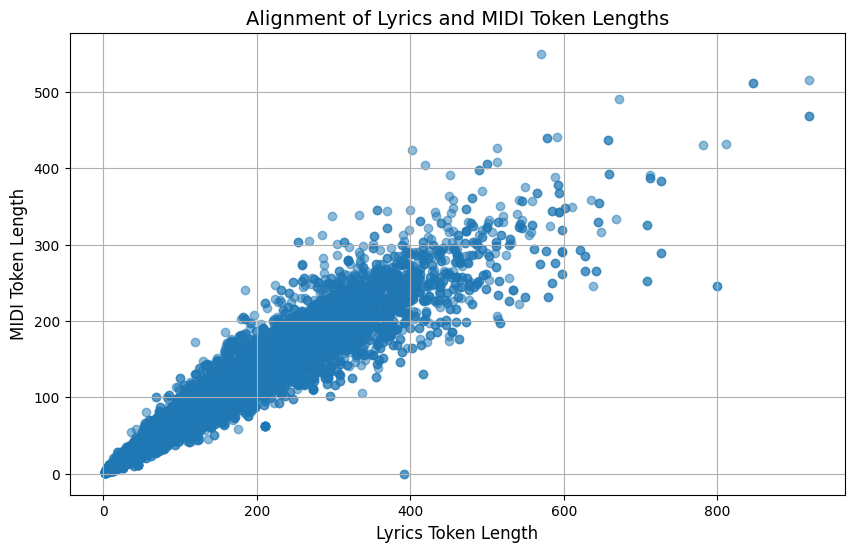

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(lyrics_data['tokenized_length'], lyrics_data['midi_tokenized_length'], alpha=0.5)
plt.title("Alignment of Lyrics and MIDI Token Lengths", fontsize=14)
plt.xlabel("Lyrics Token Length", fontsize=12)
plt.ylabel("MIDI Token Length", fontsize=12)
plt.grid(True)
plt.show()


In [6]:
# Identify outliers (e.g., sequences longer than max length or shorter than a threshold)
lyrics_outliers = lyrics_data[lyrics_data['tokenized_length'] > 512]
midi_outliers = lyrics_data[lyrics_data['midi_tokenized_length'] > 512]

print(f"Lyrics outliers (length > 512): {len(lyrics_outliers)}")
print(f"MIDI outliers (length > 512): {len(midi_outliers)}")

# # remove outliers
# lyrics_data = lyrics_data[
#     (lyrics_data['lyrics_tokenized_length'] <= 512) &
#     (lyrics_data['midi_tokenized_length'] <= 512)
# ]


Lyrics outliers (length > 512): 129
MIDI outliers (length > 512): 2


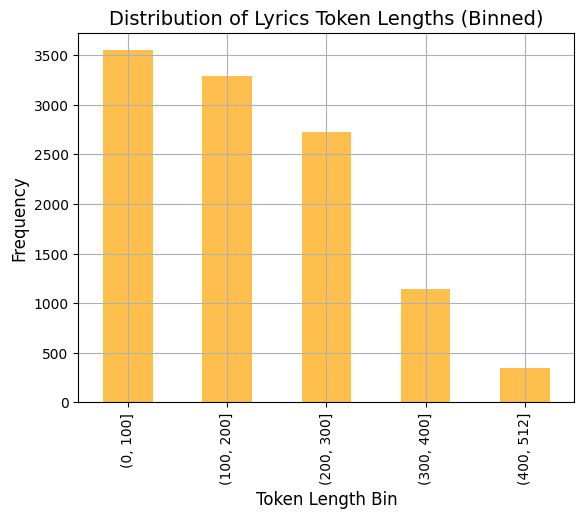

In [7]:
# Group by length bins
lyrics_data['lyrics_length_bin'] = pd.cut(lyrics_data['tokenized_length'], bins=[0, 100, 200, 300, 400, 512])
length_distribution = lyrics_data['lyrics_length_bin'].value_counts()

# Plot the distribution
length_distribution.plot(kind='bar', color='orange', alpha=0.7)
plt.title("Distribution of Lyrics Token Lengths (Binned)", fontsize=14)
plt.xlabel("Token Length Bin", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.show()


In [8]:
# import random
# from copy import deepcopy
# def randomize_midi_pitch(midi_score, prob=0.2, max_change=4):
#     """
#     Randomly changes the pitch of notes in a MIDI score.

#     Args:
#         midi_score (Score): A Score object representing the MIDI file.
#         prob (float): Probability of changing a note's pitch.
#         max_change (int): Maximum semitone change (+/-).

#     Returns:
#         Score: The modified Score object.
#     """
#     new_score = deepcopy(midi_score)
#     for track in new_score.tracks:
#         for note in track.notes:
#             if random.random() < prob:
#                 change = random.randint(-max_change, max_change)
#                 note.pitch = max(0, min(note.pitch + change, 127))
#     return new_score

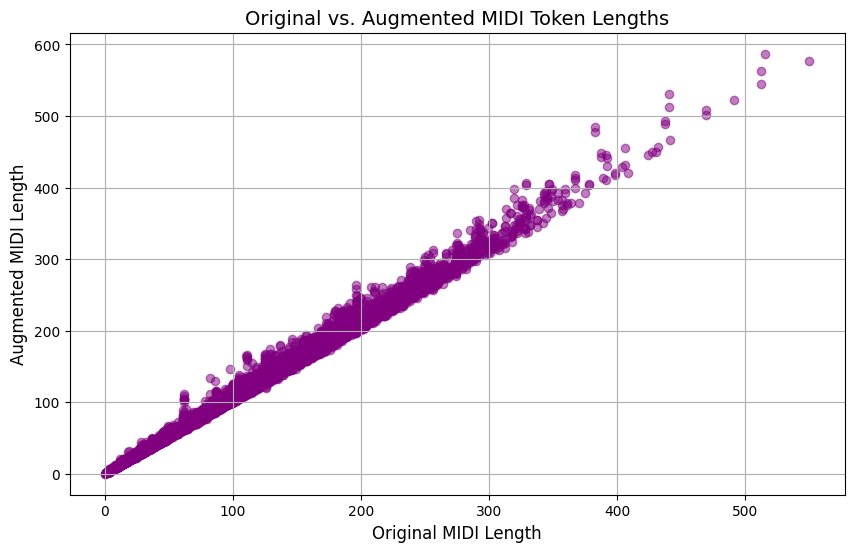

In [5]:
# Tokenize augmented MIDI
from src.data import randomize_midi_pitch
lyrics_data['augmented_midi_length'] = lyrics_data['midi_path'].apply(
    lambda path: len(midi_tokenizer.encode(randomize_midi_pitch(Score(path)))[0].ids)
)

# Compare original and augmented lengths
plt.figure(figsize=(10, 6))
plt.scatter(lyrics_data['midi_tokenized_length'], lyrics_data['augmented_midi_length'], alpha=0.5, color='purple')
plt.title("Original vs. Augmented MIDI Token Lengths", fontsize=14)
plt.xlabel("Original MIDI Length", fontsize=12)
plt.ylabel("Augmented MIDI Length", fontsize=12)
plt.grid(True)
plt.show()

In [10]:
# Tokenize all lyrics and collect unique tokens
lyrics_vocab = set()
lyrics_data['lyrics'].apply(lambda x: lyrics_vocab.update(lyrics_tokenizer.tokenize(x)))
print(f"Lyrics Vocabulary Size: {len(lyrics_vocab)}")

# Analyze token frequencies

all_tokens = []
lyrics_data['lyrics'].apply(lambda x: all_tokens.extend(lyrics_tokenizer.tokenize(x)))
token_counts = Counter(all_tokens)

print(f"Most Common Tokens: {token_counts.most_common(10)}")
print(f"Least Common Tokens: {token_counts.most_common()[:-11:-1]}")


Lyrics Vocabulary Size: 17192
Most Common Tokens: [('Ċ', 336706), ('Ġthe', 49658), ('Ġyou', 46282), ('ĠI', 37004), ('Ġto', 32254), ('Ġme', 27461), ('Ġa', 27344), ('I', 26530), ('Ġmy', 19357), ('Ġin', 16748)]
Least Common Tokens: [('ĠAudrey', 1), ('ĠMC', 1), ('Ġlac', 1), ('ĠFriendship', 1), ('NOR', 1), ('ATOR', 1), ('ANI', 1), ('REL', 1), ('ĠCOP', 1), ('PI', 1)]


In [7]:
from collections import Counter
# Tokenize all MIDI sequences and collect unique tokens
midi_vocab = set()
lyrics_data['midi_path'].apply(lambda path: midi_vocab.update(midi_tokenizer.encode(Score(path))[0].ids))
print(f"MIDI Vocabulary Size: {len(midi_vocab)}")

# Analyze MIDI token frequencies
all_midi_tokens = []
lyrics_data['midi_path'].apply(lambda path: all_midi_tokens.extend(midi_tokenizer.encode(Score(path))[0].ids))
midi_token_counts = Counter(all_midi_tokens)

print(f"Most Common MIDI Tokens: {midi_token_counts.most_common(10)}")
print(f"Least Common MIDI Tokens: {midi_token_counts.most_common()[:-11:-1]}")

MIDI Vocabulary Size: 29851
Most Common MIDI Tokens: [(224, 9833), (254, 5387), (167, 4240), (182, 4050), (187, 3978), (156, 3817), (189, 3690), (152, 3664), (204, 3626), (169, 3597)]
Least Common MIDI Tokens: [(16486, 1), (22329, 1), (22670, 1), (23948, 1), (17205, 1), (22533, 1), (22535, 1), (121, 1), (120, 1), (114, 1)]
